# Import packages, define helper function

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import set_gpu_default_device

In [2]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only precision with datetime64[D].
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with time as datetime64[D].
    """
    if 'time' in ds.coords:
        # Convert time to day-level precision
        ds['time'] = ds['time'].dt.floor('D').values.astype('datetime64[D]')
    
    return ds

# Data Inventory and Preprocessing

### Temporal datasets: SST, ice concentration

In [3]:
# Path to your Zarr stores
ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

### Static datasets: lake mask, bathymetry

In [4]:
# Set up GCS filesystem
fs = gcsfs.GCSFileSystem(project='your-gcp-project')

# Path to the NetCDF files 
context_path = 'gs://great-lakes-osd/context/'

# Open the NetCDF files using xarray with gcsfs
bathymetry_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'interpolated_bathymetry.nc')))
lakemask_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'lakemask.nc')))

# Name the bathymetry variable
bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

# Data Processor

In [5]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': None, 'name': 'lat'},
            'x2': {'map': None, 'name': 'lon'}}}


In [6]:
#glsea = data_processor(glsea_raw)
_ = data_processor(glsea_raw.sel(time=slice("2009-01-01", "2009-12-31")))
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
bathymetry, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [75]:
# Select a subset of the ice concentration data to compute normalization parameters
_ = data_processor(ice_concentration_raw.sel(time=slice("2009-01-01", "2009-12-31")))

# Now apply the normalization parameters to the full ice concentration dataset
ice_concentration = data_processor(ice_concentration_raw)

In [76]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}},
 'ice_concentration': {'method': 'mean_std',
  'params': {'mean': 11.848304453395341, 'std': 28.78266463694381}},
 'dummy': {'method': 'mean_std', 'params': {'mean': 0.0, 'std': 0.0}}}

In [9]:
dates = pd.date_range(glsea.time.values.min(), glsea.time.values.max(), freq="D")

In [10]:
doy_ds = construct_circ_time_ds(dates, freq="D")
cosD = standardize_dates(doy_ds["cos_D"])
sinD = standardize_dates(doy_ds["sin_D"])

In [11]:
sinD

<xarray.DataArray 'sin_D' (time: 10227)> Size: 82kB
array([ 0.017202,  0.034398,  0.051584, ..., -0.038696, -0.021501, -0.004301],
      shape=(10227,))
Coordinates:
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31

# Sanity checks after being run through the data_processor

### Sanity check: ice concentration

In [12]:
ice_concentration

<xarray.Dataset> Size: 155GB
Dimensions:            (time: 18434, x1: 1024, x2: 1024)
Coordinates:
  * time               (time) datetime64[s] 147kB 1972-12-01 ... 2023-05-21
  * x1                 (x1) float64 8kB 0.7091 0.7085 ... 0.0007282 -3.551e-05
  * x2                 (x2) float64 8kB 0.0005654 0.001543 ... 0.9998 1.001
Data variables:
    ice_concentration  (time, x1, x2) float64 155GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes: (12/23)
    coverage_area:            Great Lakes
    data_source:              NOAA
    description:              Great Lakes ice concentrations
    disclaimer:               Data collected and processed by NOAA and dissem...
    dissemination:            USNIC Website, CIS Website
    grid_resolution:          1.800 km
    ...                       ...
    product:                  GRID - Resolution 1800
    source:                   NAIS daily Great Lakes ice analysis
    source_url:               https://noaadata.apps.nsidc.org/NOAA/G10029/
    spatial_extent:           Lat: 38.87N to 50.6N, Lon: 92.41W to 75.87W
    time_range:               2009-01-01 to 2009-12-31
    units:                    Ice concentration (%)

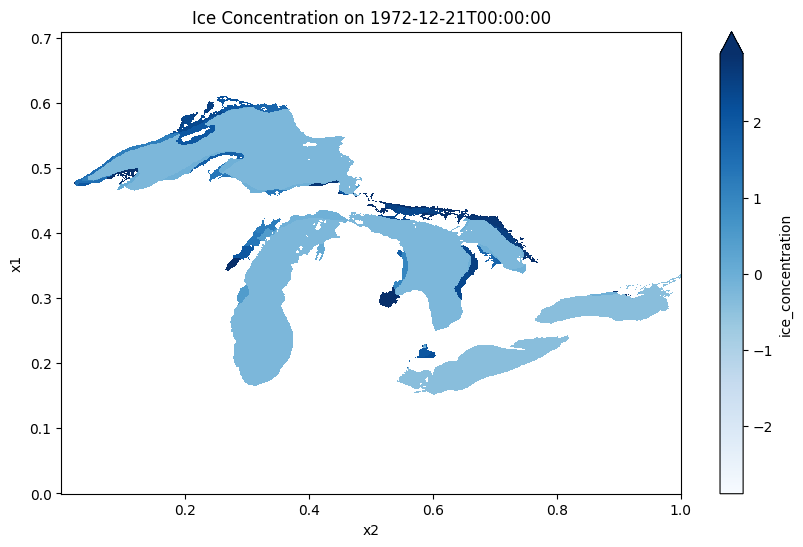

In [13]:
# Load the dataset
ds = ice_concentration

# Select a single time slice to plot, e.g., the first time point
time_index = 20
time_slice = ds.isel(time=time_index)

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = time_slice.ice_concentration.plot(
    x='x2', 
    y='x1', 
    cmap='Blues',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"Ice Concentration on {str(time_slice.time.values)}")
plt.show()

### Sanity check: GLSEA

In [14]:
glsea

<xarray.Dataset> Size: 40GB
Dimensions:  (time: 10221, x1: 838, x2: 1181)
Coordinates:
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    sst      (time, x1, x2) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    GDAL:         GDAL 2.1.3, released 2017/20/01
    history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
    source:       1995_001_glsea.asc
    title:        SST from Great Lakes Surface Environmental Analysis (GLSEA)

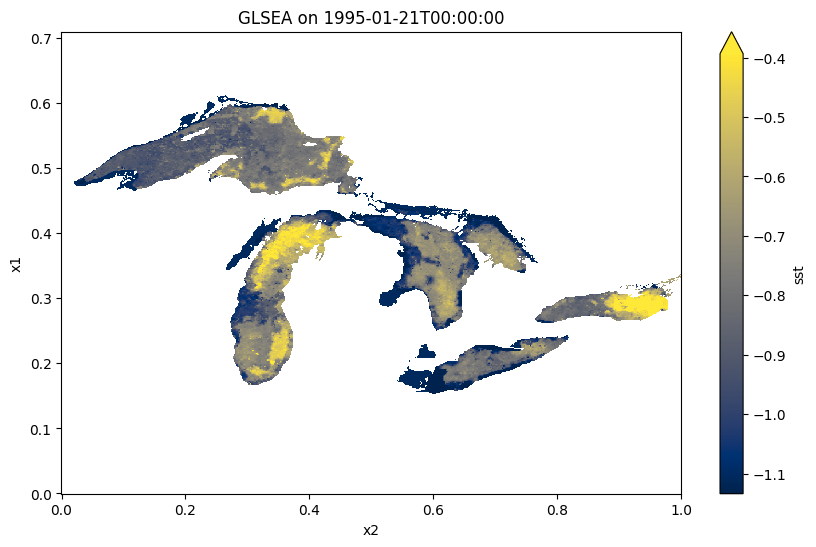

In [15]:
# Load the dataset
ds = glsea

# Select a single time slice to plot, e.g., the first time point
time_index = 20
time_slice = ds.isel(time=time_index)

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = time_slice.sst.plot(
    x='x2', 
    y='x1', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

### Sanity check: bathymetry

In [16]:
bathymetry

<xarray.Dataset> Size: 696kB
Dimensions:     (x1: 240, x2: 360)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan

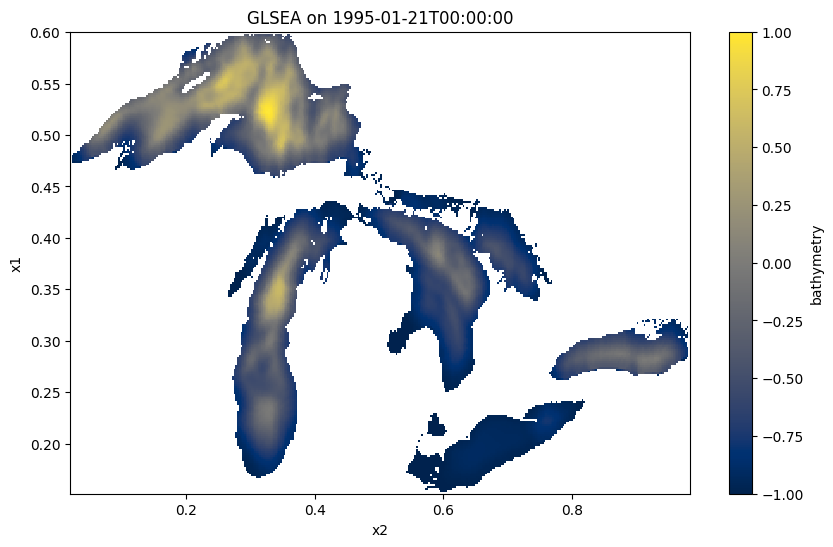

In [17]:
# Load the dataset
ds = bathymetry

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = ds.bathymetry.plot(
    x='x2', 
    y='x1', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

### Sanity check: lake mask

In [18]:
lakemask

<xarray.Dataset> Size: 4MB
Dimensions:  (x1: 838, x2: 1181)
Coordinates:
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    mask     (x1, x2) float32 4MB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0

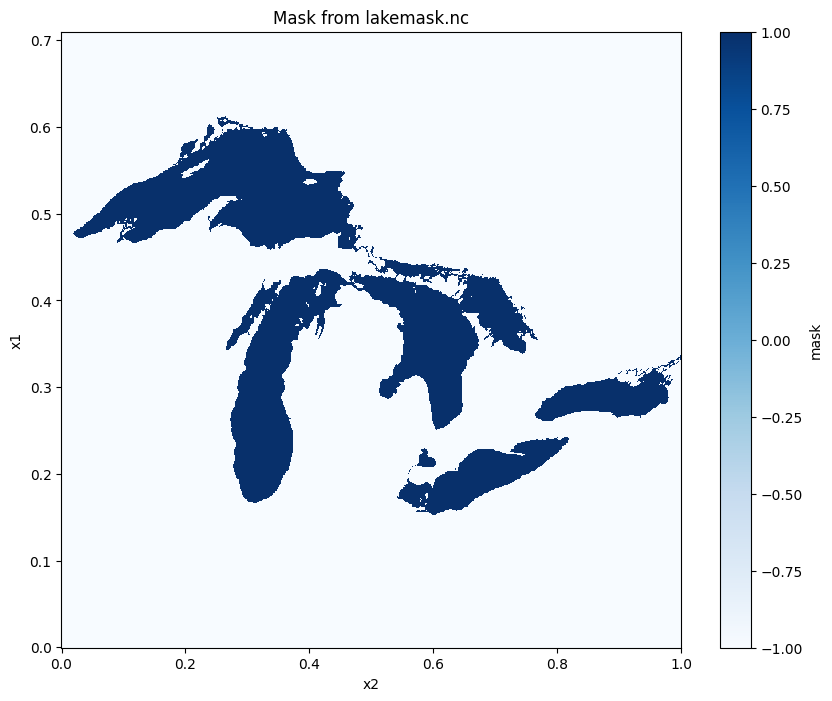

In [19]:
# Plot lakemask
lakemask_mask = lakemask['mask']

# Plot the data
plt.figure(figsize=(10, 8))
lakemask_mask.plot(cmap='Blues', add_colorbar=True)
plt.title('Mask from lakemask.nc')
plt.show()

# Tasks

## Generating random coordinates from inside the mask

In [85]:
def generate_random_coordinates(mask_da, N, data_processor=None):
    """
    Generate N random coordinates (lat, lon) from a mask with values 1 inside the lake area,
    and normalize them using the DataProcessor if provided.
    
    Parameters:
    mask_da: xarray DataArray containing the mask (with 1 for valid, 0 for invalid areas)
    N: Number of random points to generate
    data_processor: (optional) DataProcessor object for normalization if needed
    
    Returns:
    numpy.ndarray: Array of shape (2, N) with random latitudes and longitudes from the masked region
    """
    
    # Get the valid indices where the mask is 1
    mask = mask_da['mask'].values
    valid_indices = np.argwhere(mask == 1)
    
    # Randomly sample N points from the valid indices
    random_indices = valid_indices[np.random.choice(valid_indices.shape[0], N, replace=False)]
    
    # Get the latitude and longitude coordinates for the sampled indices
    latitudes = mask_da['lat'].values[random_indices[:, 0]]
    longitudes = mask_da['lon'].values[random_indices[:, 1]]
    
    # Create a dummy variable (e.g., zeros for now)
    dummy_variable = np.random.rand(N)
    
    # Create a Pandas DataFrame with latitudes, longitudes, and the dummy variable
    random_coords_df = pd.DataFrame({
        'lat': latitudes,
        'lon': longitudes,
        'dummy': dummy_variable
    })
    
    # Set the index to ['lat', 'lon'] to match what DataProcessor expects
    random_coords_df = random_coords_df.set_index(['lat', 'lon'])
    
    if data_processor:
        normalized_coords_df = data_processor(random_coords_df, method="min_max")
        return normalized_coords_df.index.to_frame(index=False).values.T
    else:
        return np.vstack((latitudes, longitudes))


In [100]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)
random_lake_points

array([[0.56864407, 0.56355932, 0.42711864, 0.17033898, 0.56186441,
        0.19237288, 0.48728814, 0.51186441, 0.47288136, 0.38389831,
        0.36610169, 0.21016949, 0.46610169, 0.38305085, 0.52372881,
        0.17627119, 0.41101695, 0.50762712, 0.50254237, 0.51864407,
        0.22457627, 0.21610169, 0.3940678 , 0.53220339, 0.53389831,
        0.33050847, 0.23983051, 0.56440678, 0.21186441, 0.57033898,
        0.33305085, 0.49830508, 0.43898305, 0.53983051, 0.35      ,
        0.17627119, 0.54576271, 0.47288136, 0.39915254, 0.20932203,
        0.19067797, 0.50169492, 0.38983051, 0.56355932, 0.28474576,
        0.18559322, 0.56949153, 0.31864407, 0.38474576, 0.37033898,
        0.48135593, 0.49491525, 0.2940678 , 0.21440678, 0.30169492,
        0.51610169, 0.41355932, 0.23983051, 0.58813559, 0.32457627,
        0.49915254, 0.53898305, 0.50677966, 0.49152542, 0.23813559,
        0.3559322 , 0.47881356, 0.39152542, 0.39576271, 0.24491525,
        0.29322034, 0.39745763, 0.59576271, 0.51

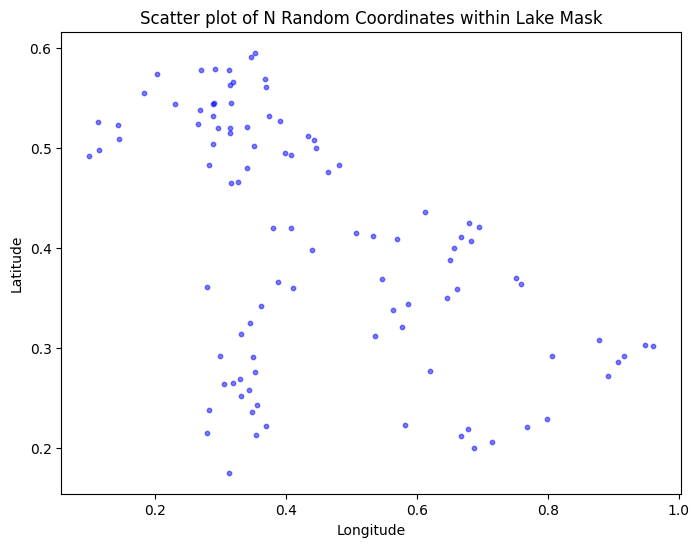

In [91]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [92]:
from deepsensor.data import TaskLoader
task_loader = TaskLoader(context=[glsea, ice_concentration, bathymetry, lakemask], target=glsea)

In [93]:
task_loader.context

(<xarray.Dataset> Size: 40GB
 Dimensions:  (time: 10221, x1: 838, x2: 1181)
 Coordinates:
   * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
   * x1       (x1) float32 3kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
   * x2       (x2) float32 5kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
 Data variables:
     sst      (time, x1, x2) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
 Attributes:
     CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
     CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
     Conventions:  CF-1.5
     GDAL:         GDAL 2.1.3, released 2017/20/01
     history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
     source:       1995_001_glsea.asc
     title:        SST from Great Lakes Surface Environmental Analysis (GLSEA),
 <xarray.Dataset> Size: 77GB
 Dimensions:            (time: 18434, x1: 1024, x2: 1024)
 Coordinates:
   * time

In [94]:
task = task_loader("2011-08-16T00:00:00", context_sampling=random_lake_points, target_sampling="all")

In [95]:
task

time: Timestamp/2011-08-16 00:00:00
ops: []
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)']
X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
Y_t: ['ndarray/float32/(1, 838, 1181)']

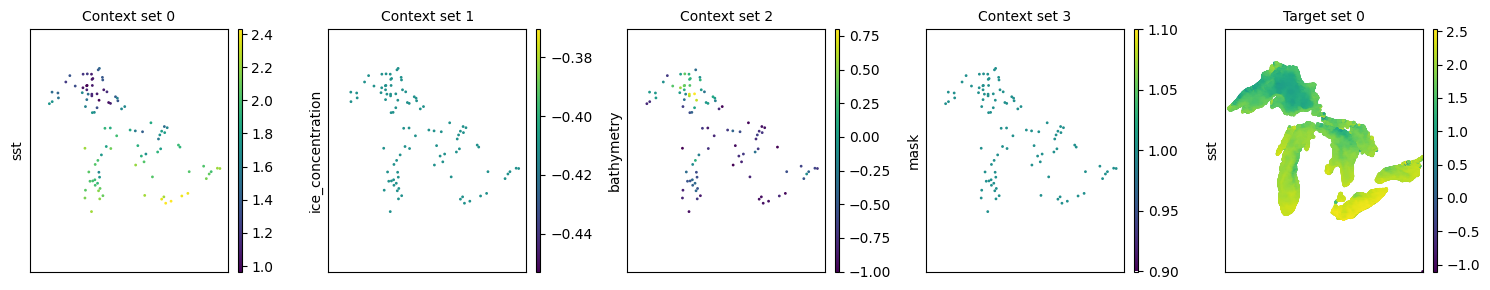

In [96]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()

## Attempt task with points sampled from lakes only

In [97]:
task = task_loader("2011-08-16T00:00:00", context_sampling=random_lake_points, target_sampling="all")

In [98]:
task

time: Timestamp/2011-08-16 00:00:00
ops: []
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)']
X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
Y_t: ['ndarray/float32/(1, 838, 1181)']

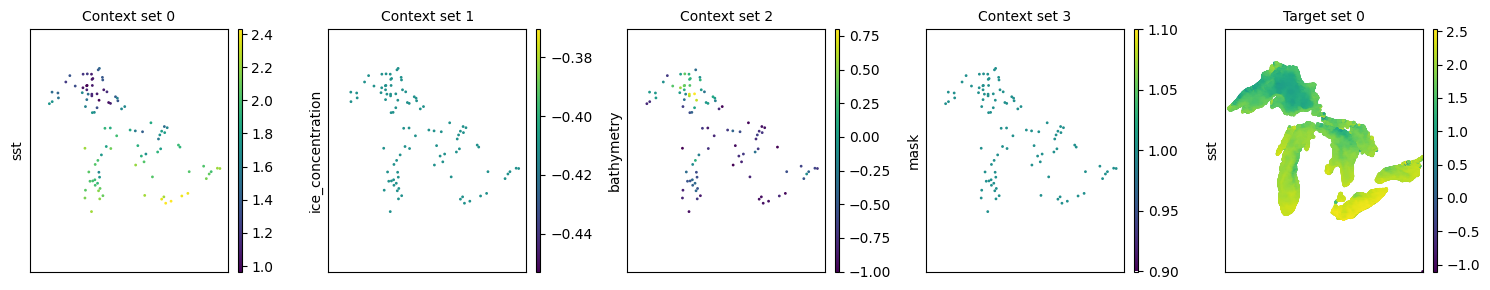

In [99]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()